# Guppy Demo

This demo notebook gives an overview of currently implemented Guppy features. For further details see the [Guppy Confluence page](https://cqc.atlassian.net/wiki/spaces/TKET/pages/2617933825/GUPPY+Draft).

In [1]:
import sys
sys.path.append("..")

from guppy.hugr.hugr import Hugr
from guppy.visualise import hugr_to_graphviz
from guppy.compiler import GuppyModule, guppy

setattr(
    Hugr,
    "_repr_svg_",
    lambda self: hugr_to_graphviz(self)._repr_svg_(),
)

## Intro

To get started, you can use the `@guppy` decorator to compile a single function without having to declare a module:

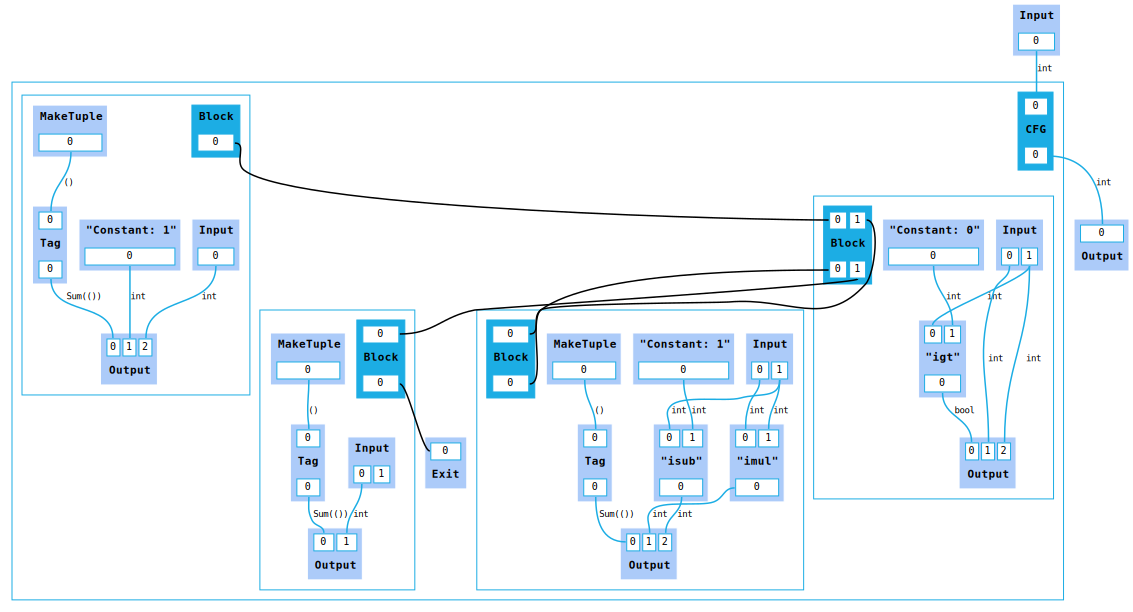

In [2]:
@guppy
def factorial(x: int) -> int:
    acc = 1
    while x > 0:
        acc *= x
        x -= 1
    return acc

factorial

Guppy can handle arbitrary Python control flow involving `if`, `while`, `continue`, `break`, and `return`. Many Python functions should be directly compilable. The main difference compared to regular Python is that Guppy functions must obey the following key rule to be compilable:

> **When a variable is used, it must be defined on any control flow path leading to this point and have the same type on all of those paths.**

Importantly, this only matters if a variable is used. For example, the following code is fine:

In [3]:
@guppy
def no_usage(x: int) -> int:
    if x > 0:
        a = 10
    else:
        a = "test"
    return x

However, if we use `a` then compilation will fail:

In [4]:
@guppy
def bad_fun(x: int) -> int:
    if x > 0:
        a = 10
    else:
        a = "test"
    x += a
    return x

Guppy compilation failed. Error in file "/var/folders/tw/395bz2tx0nv7wnltsw_zk7740000gn/T/ipykernel_26012/1961601748.py", line 7, in __main__

5:    else:
6:        a = "test"
7:    x += a
           ^
GuppyError: Variable `a` can refer to different types: `int` (at 4:8) vs `str` (at 6:8)


## Functional Statements

Every Guppy statement can be annotated with the pseudo-decorator `_@functional`. At the moment, this only affects `if` and `while` statements and forces them to be compiled using `gamma` and `theta` nodes instead of `kappa`:

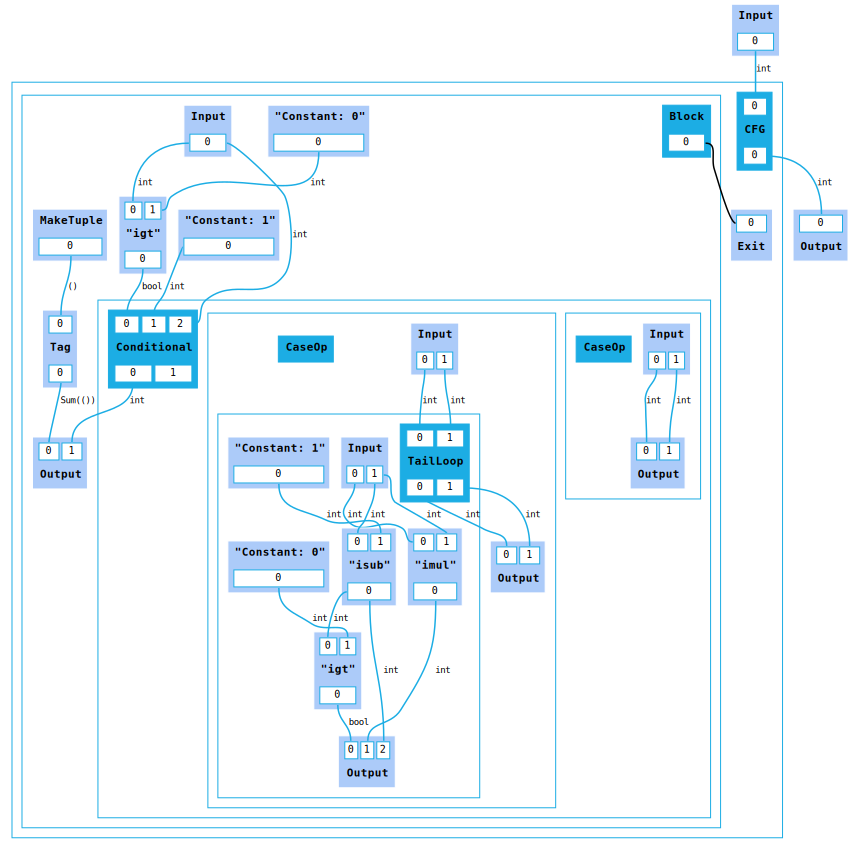

In [5]:
@guppy
def factorial2(x: int) -> int:
    acc = 1
    _@functional
    while x > 0:
        acc *= x
        x -= 1
    return acc

factorial2

At the moment `return`, `break`, and `continue` are not allowed inside of functional statements:

In [6]:
@guppy
def bad_functional(x: int) -> int:
    _@functional
    if x > 5:
        return 5
    return x

Guppy compilation failed. Error in file "/var/folders/tw/395bz2tx0nv7wnltsw_zk7740000gn/T/ipykernel_26012/1156639282.py", line 5, in __main__

3:    _@functional
4:    if x > 5:
5:        return 5
          ^^^^^^^^
GuppyError: Return is not allowed in a functional statement


## Arithmetic

Guppy supports all arithmetic operations and has implicit `int` to `float` coercion when applying those operations:

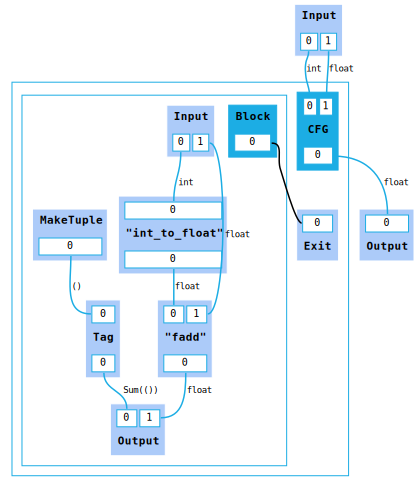

In [7]:
@guppy
def arith1(x: int, y: float) -> float:
    return x + y

arith1

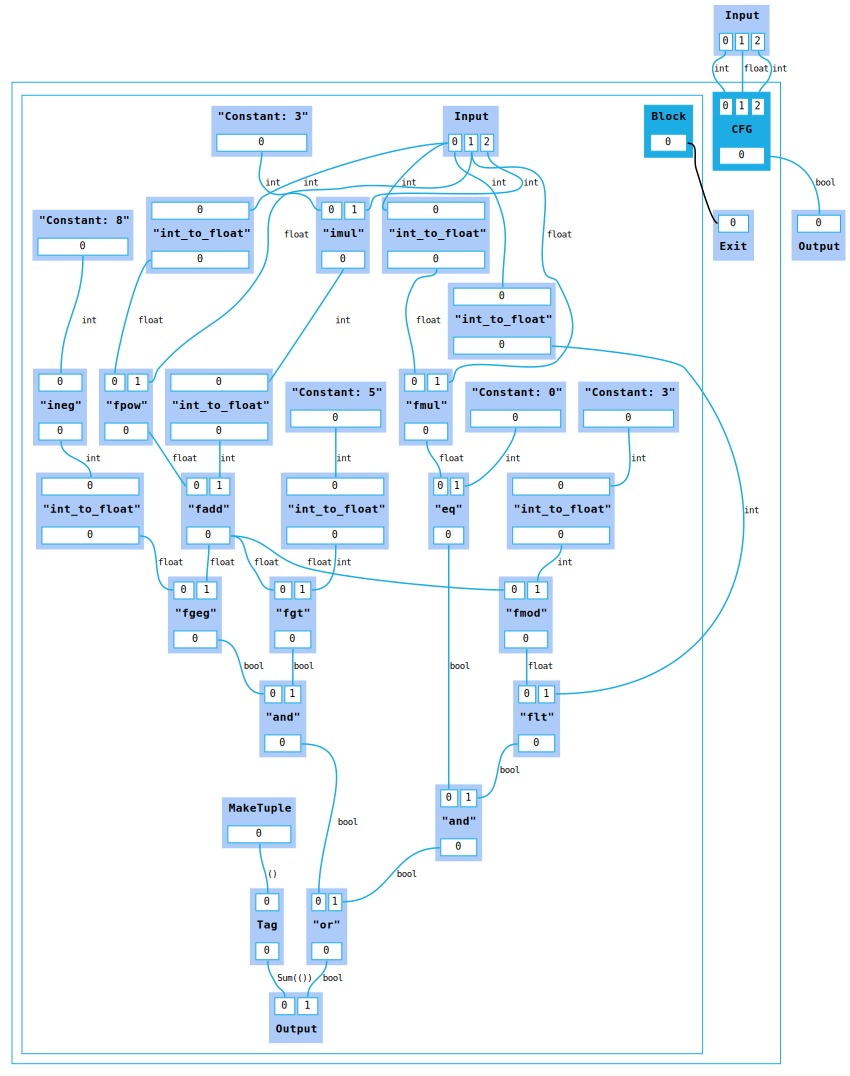

In [8]:
@guppy
def arith2(x: int, y: float, z: int) -> bool:
    a = x**y + 3*z
    b = -8 >= a > 5 or (x*y == 0 and a % 3 < x)
    return b

arith2

## Modules

In order to use recursion, guppy functions must be placed inside of a module:

In [9]:
module = GuppyModule("fac_module")

@module
def factorial3(x: int) -> int:
    if x == 0:
        return 1
    return factorial3(x-1) * x

Compilation of modules needs to be triggered separately, after all functions are defined (in order to support mutual recursion):

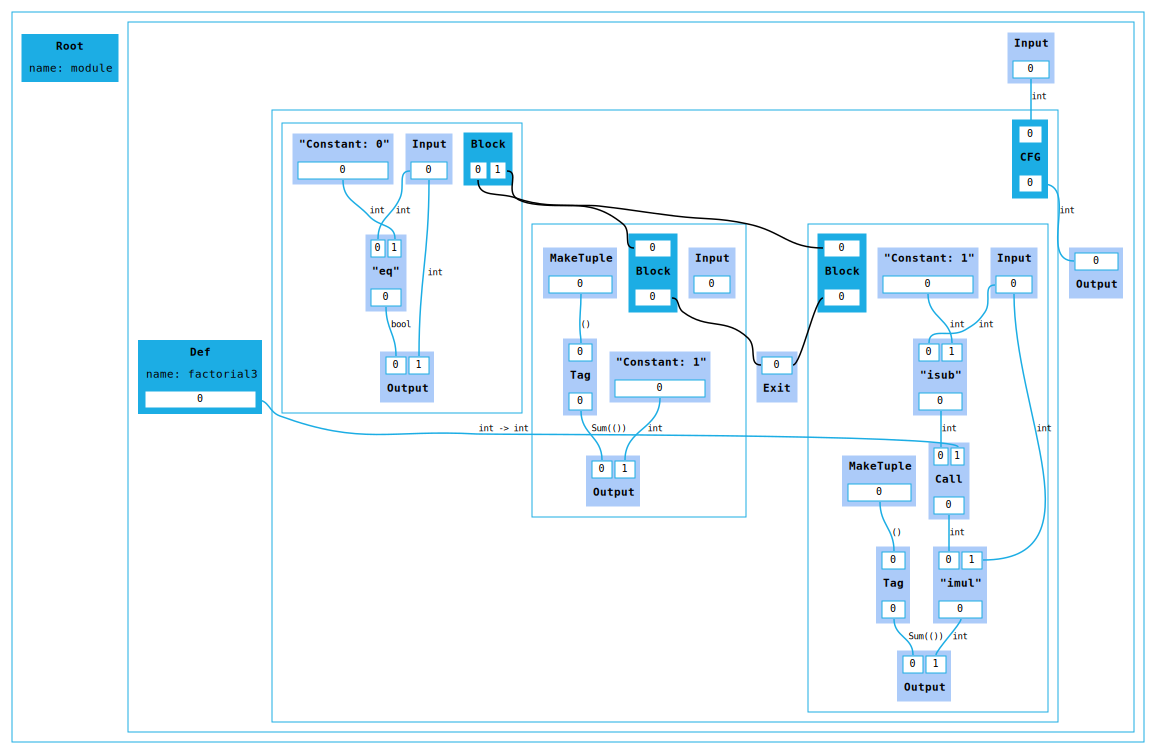

In [10]:
module.compile()

Below is an easy example of mutual recursion:

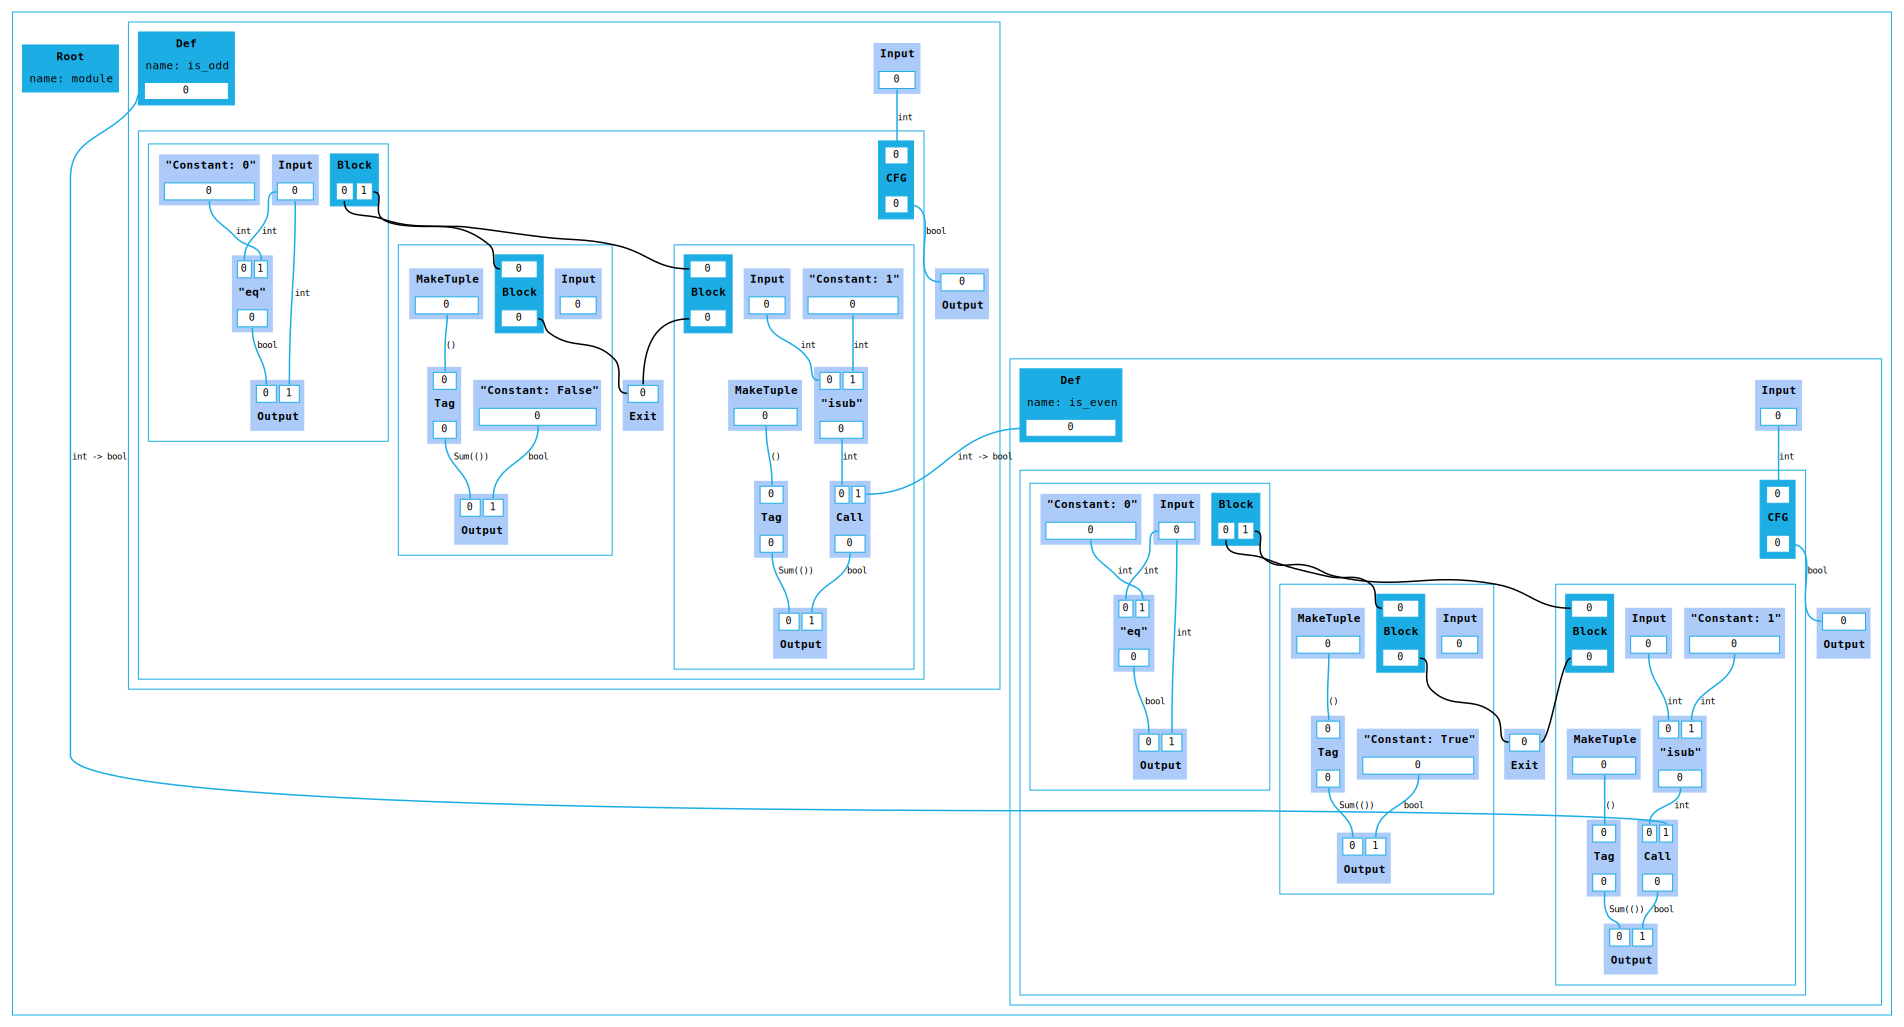

In [11]:
module = GuppyModule("fac_module")

@module
def is_even(x: int) -> bool:
    if x == 0:
        return True
    return is_odd(x-1)

@module
def is_odd(x: int) -> bool:
    if x == 0:
        return False
    return is_even(x-1)

module.compile()